# Routing using Particle Swarm Optimization

Particle Swarm Optimization (PSO) works by generating a number of candidates (or particles) and moving those candidates along the search space in search of the optimal solution. Each particle moves according to some predefined rules, which are influenced by the currently known best position, as well as the universally known best position.

Essentially, each particle takes into account the following:
1. Predetermined rules for movement.
2. What the particle knows about the best direction to move.
3. What the system as a whole knows about the best direction to move.

This mechanism allows the collective whole to "swarm" or congregate towards good solutions, and replicates the behaviours of natural swarms and flocks, such as those seen in birds, fish, or bees.

In [1]:
import random
import itertools
import osmnx
from optalgotools.structures import Node
from optalgotools.routing import randomized_search
from optalgotools.routing import draw_route
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Create a cost function

In [2]:
def cost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        weight += G[u][v][0]['length']   
    return round(weight,4)

### Define a probability function

In [3]:
def probability(p):
    return p > random.uniform(0.0, 1.0)

### Define crossover function to generate particles

In [4]:
def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[-1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.50):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

### Define the orgin and destination points and createa  road network graph

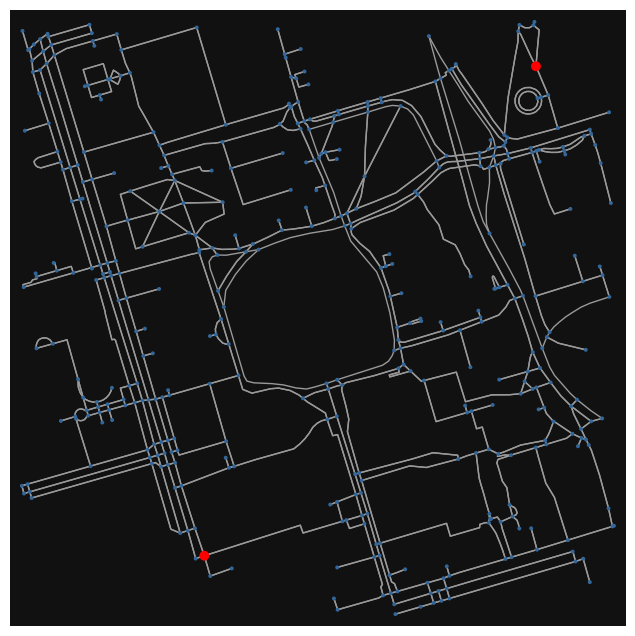

In [5]:
reference = (43.661667, -79.395)

G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

highlighted = [389677909, 55808290]

# marking both the source and destination node
nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

### Initialize the swarm

In [6]:
n = 200
particles = [randomized_search(G,origin.osmid, destination.osmid) for _ in range(n)]
num_swarms = 4
num_iterations = 100

# Used to track the costs for analysis
swarm_costs = []

### Find the shortest route using PSO

In [7]:
for iteration in tqdm(range(num_iterations)):
    particles.sort(key=lambda p: cost(G,p))
    pps = n // num_swarms # particles per swarm

    # We select the best particles in each swarm to lead
    leaders = particles[:pps][:]

    for i in range(num_swarms):
        particles[i] , particles[i * (pps) - 1] = particles[i * (pps) - 1], particles[i]
    
    swarms = list()
    for i in range(num_swarms):
        swarms.append(particles[i * (pps): i*(pps) + pps])

    # For each swam, we need to follow the leader of that swarm

    # follow the leader of the local swarm
    def local_follow(population):
        for i in range(1, len(population)):
            population[i] = cross_over(population[0],population[i])

    # follow the global leader
    def global_follow():
        for u, v in itertools.product(range(0, len(leaders)), range(0, len(leaders))):
            to_be_mutated = random.choice([u, v])
            leaders[to_be_mutated] = cross_over(leaders[u], leaders[v])
    
    for swarm in swarms:
        local_follow(swarm)
    
    global_follow()

    # Add the new leaders
    particles[i*(pps-1)] = leaders[i]

    # Track the lowest cost in each swarm
    swarms = list()
    for i in range(num_swarms):
        swarms.append(particles[i * (pps): i*(pps) + pps])

    cost_set = []
    for swarm in swarms:
        lowest =min([cost(G,p) for p in swarm])
        cost_set.append(lowest)
    swarm_costs.append(cost_set)

  0%|          | 0/100 [00:00<?, ?it/s]

### Print the cost of the shortest route and visualize it

In [8]:
route = min(particles, key=lambda p: cost(G,p))
print("Cost:",cost(G,route))
draw_route(G, route)

Cost: 813.0


### Plot the search history

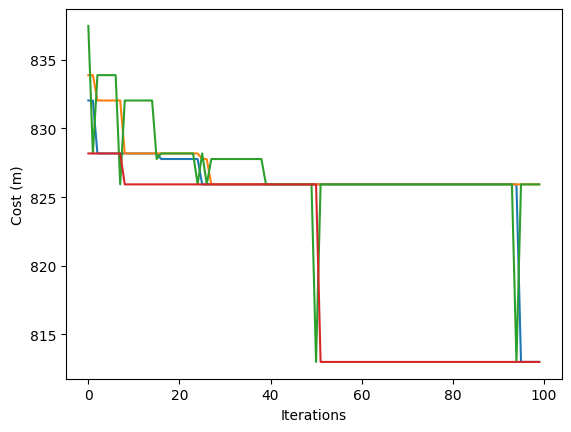

In [9]:
plt.plot(swarm_costs)
plt.xlabel('Iterations')
plt.ylabel('Cost (m)')
plt.show()